0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

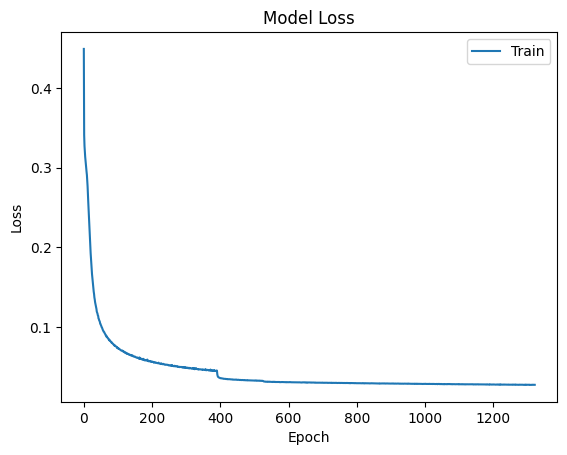

Seed sequence shape: (12, 5)


Generating Data: 100%|██████████| 15108/15108 [08:30<00:00, 29.61it/s]


new_times length: 15108, new_data length: 15108
新數據存到: generated_data.csv
Original Data Statistics:
            GloblRad            WH   Temperature            RH           UVI
count  15108.000000  15108.000000  15108.000000  15108.000000  15108.000000
mean       1.365064   9941.400053     26.028250     67.603455      3.220214
std        0.997138   7065.895864      5.140385     13.022543      3.028104
min        0.000000      0.000000      7.500000     14.000000      0.000000
25%        0.440000   3281.750000     22.600000     59.000000      1.000000
50%        1.240000   9287.000000     26.900000     66.000000      2.000000
75%        2.200000  16150.750000     30.100000     76.000000      5.000000
max        3.760000  25545.000000     36.300000     99.000000     14.000000
Generated Data Statistics:
            GloblRad            WH   Temperature            RH           UVI
count  15108.000000  15108.000000  15108.000000  15108.000000  15108.000000
mean       1.364026   9928.543163  

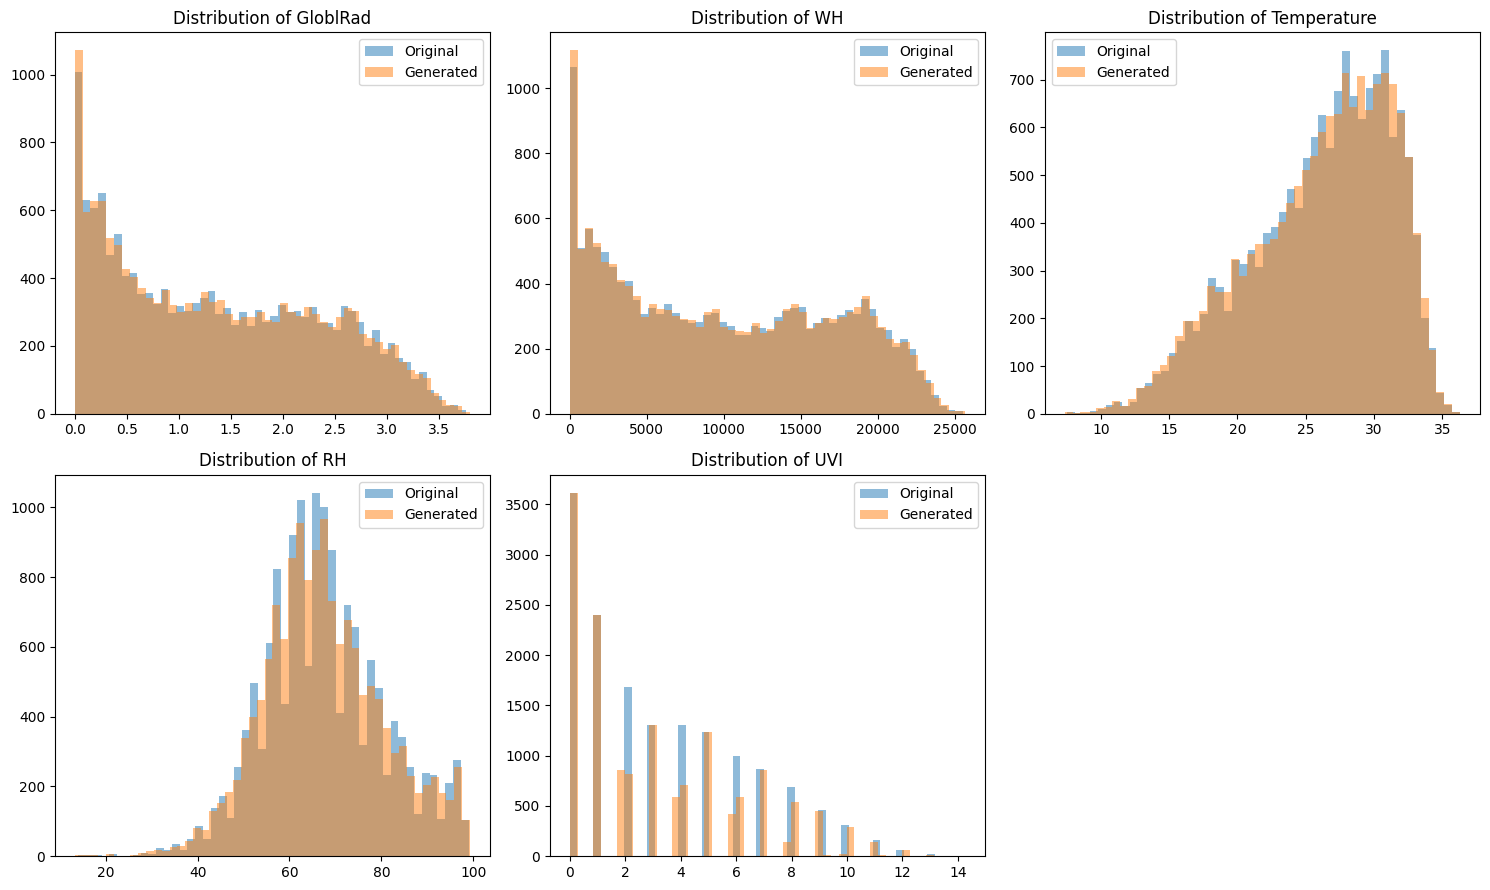

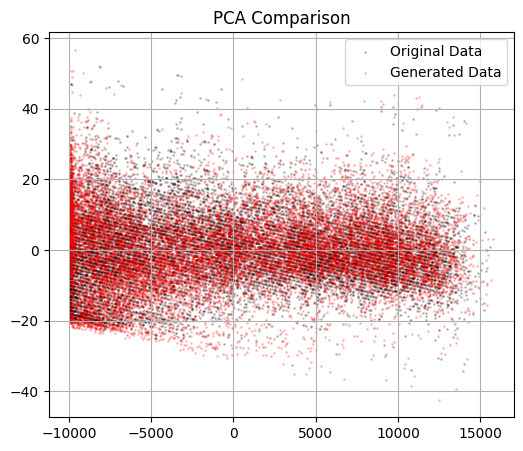

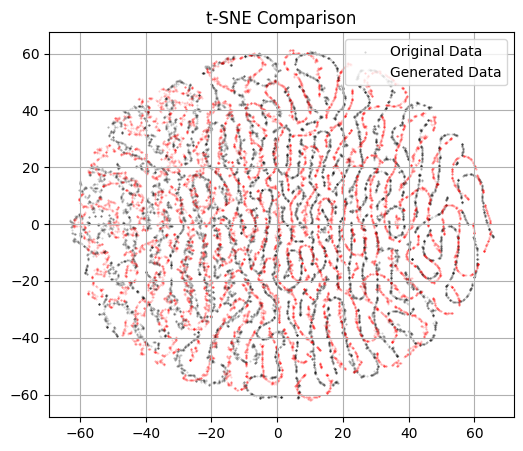

GloblRad    : - ANOVA F-statistic: 8.1377e-03  , p-value: 9.2812e-01
WH          : - ANOVA F-statistic: 2.4910e-02  , p-value: 8.7459e-01
Temperature : - ANOVA F-statistic: 1.4283e-01  , p-value: 7.0549e-01
RH          : - ANOVA F-statistic: 2.6382e-01  , p-value: 6.0751e-01
UVI         : - ANOVA F-statistic: 3.7986e-02  , p-value: 8.4547e-01
Fold 1 RMSE: 0.0481
Fold 2 RMSE: 0.0497
Fold 3 RMSE: 0.0612
Fold 4 RMSE: 0.0465
Fold 5 RMSE: 0.0456
Cross-validated RMSE: 0.0502


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, LeakyReLU
from keras.callbacks import EarlyStopping, History, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from tqdm.keras import TqdmCallback
from tqdm import tqdm
from scipy.stats import f_oneway

file_path = 'processed_data.csv'
data = pd.read_csv(file_path)
features = ['GloblRad', 'WH', 'Temperature', 'RH', 'UVI']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[features])

#數據增強
def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def time_reverse(data):
    return data[::-1]

def random_erase(data, erase_prob=0.1):
    mask = np.random.rand(*data.shape) > erase_prob
    return data * mask

def smooth_data(data, window_size=3):
    smoothed_data = []
    for i in range(data.shape[0]):
        smoothed_row = np.convolve(data[i], np.ones(window_size)/window_size, mode='same')
        smoothed_data.append(smoothed_row)
    return np.array(smoothed_data)

noisy_data = add_noise(scaled_data, noise_level=0.01)
time_reverse_data = time_reverse(scaled_data)
random_erase_data = random_erase(scaled_data)
augmented_smooth_data = smooth_data(scaled_data)
augmented_data = np.concatenate((scaled_data, noisy_data), axis=0)
###########

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

seq_length = 12 
sequences = create_sequences(augmented_data, seq_length + 1)

X_train = sequences[:, :-1, :]
y_train = sequences[:, -1, :]  

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))

model = Sequential()
model.add(LSTM(512, input_shape=(seq_length, X_train.shape[2]), return_sequences=True))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(X_train.shape[2]))
model.compile(optimizer=Adam(learning_rate=0.001), loss=rmse)

history = History()
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)
model.fit(X_train, y_train, epochs=1500, verbose=0, callbacks=[history, TqdmCallback(verbose=1), reduce_lr, early_stopping])
model.save('LSTM_model.h5')

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

def generate_features(model, seed_sequence, n_steps):
    generated = list(seed_sequence)
    result = []
    for i in tqdm(range(n_steps), desc="Generating Data"):
        x_input = np.array(generated[-seq_length:]).reshape((1, seq_length, X_train.shape[2]))
        yhat = model.predict(x_input, verbose=0)
        result.append(yhat[0])
        generated.append(yhat[0])
    return np.array(result)

seed_sequence = sequences[-1, :-1, :]
print(f"Seed sequence shape: {seed_sequence.shape}")

new_data_length = len(data) 
new_data = generate_features(model, seed_sequence, new_data_length)


if len(new_data) == 0:
    raise ValueError("Generated data is empty. Please check the data generation process.")

last_date = pd.to_datetime(data['Time'].values[-1])
date_range = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=(new_data_length // seq_length) + 1, freq='D')

daily_times = pd.date_range("06:00", "17:00", freq="h").time 
new_times = []
for day in date_range:
    for time in daily_times:
        new_times.append(pd.Timestamp.combine(day, time))

new_times = new_times[:new_data_length]

print(f"new_times length: {len(new_times)}, new_data length: {len(new_data)}")

new_data_unscaled = scaler.inverse_transform(new_data)
new_data_unscaled = np.abs(new_data_unscaled)

new_df = pd.DataFrame(new_data_unscaled, columns=features)
new_df['Time'] = new_times

##########################
def sort_wave(data, column_indices):
    for i in range(0, len(data), 12):
        for col_index in column_indices:
            if i + 12 <= len(data):
                values = data[i:i + 12, col_index]
                values_sorted = np.sort(values)
                wave_pattern = np.concatenate([values_sorted[:6], values_sorted[6:][::-1]])
                data[i:i + 12, col_index] = wave_pattern
    return data

new_df_length = new_df.shape[0]
smooth_length = new_df_length - new_df_length % 12
new_df_smooth = new_df.iloc[:smooth_length]

columns_to_sort = ['GloblRad', 'WH', 'Temperature', 'UVI']
column_indices = [new_df_smooth.columns.get_loc(col) for col in columns_to_sort]
data_to_sort = new_df_smooth.values
sorted_data = sort_wave(data_to_sort, column_indices)

new_df_smooth = pd.DataFrame(sorted_data, columns=new_df_smooth.columns)

for column in data.columns:
    if column not in new_df_smooth.columns:
        new_df_smooth[column] = np.nan

new_df_smooth = new_df_smooth[['Time', 'WH', 'Temperature', 'RH', 'GloblRad', 'UVI']]

output_file_path = 'generated_data.csv'
new_df_smooth.to_csv(output_file_path, index=False)

print(f"新數據存到: {output_file_path}")
###################################################
for col in features:
    new_df_smooth[col] = pd.to_numeric(new_df_smooth[col], errors='coerce')

original_stats = data[features].describe()
generated_stats = new_df_smooth[features].describe()
print("Original Data Statistics:\n", original_stats)
print("Generated Data Statistics:\n", generated_stats)


################
fig, axes = plt.subplots(2, 3, figsize=(15, 9)) 
axes = axes.flatten() 

for i, feature in enumerate(features):
    axes[i].hist(data[feature], bins=50, alpha=0.5, label='Original')
    axes[i].hist(new_df_smooth[feature], bins=50, alpha=0.5, label='Generated')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].legend()

for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() 
plt.show()

# PCA
original_data_pca = PCA(n_components=2).fit_transform(data[features].values)
generated_data_pca = PCA(n_components=2).fit_transform(new_df_smooth[features].values)

plt.figure(figsize=(6, 5))
plt.scatter(original_data_pca[:, 0], original_data_pca[:, 1], color='black', alpha=0.2, s=1, marker='o', label='Original Data')
plt.scatter(generated_data_pca[:, 0], generated_data_pca[:, 1], color='red', alpha=0.2, s=1, marker='o', label='Generated Data')
plt.grid(True)
plt.legend(loc='upper right')
plt.title('PCA Comparison')
plt.show()

# t-SNE
original_data_tsne = TSNE(n_components=2, perplexity=10, n_iter=500).fit_transform(data[features].values)
generated_data_tsne = TSNE(n_components=2, perplexity=10, n_iter=500).fit_transform(new_df_smooth[features].values)

plt.figure(figsize=(6, 5))
plt.scatter(original_data_tsne[:, 0], original_data_tsne[:, 1], color='black', alpha=0.2, s=0.2, marker='o', label='Original Data')
plt.scatter(generated_data_tsne[:, 0], generated_data_tsne[:, 1], color='red', alpha=0.2, s=0.2, marker='o', label='Generated Data')
plt.grid(True)
plt.legend(loc='upper right')
plt.title('t-SNE Comparison')
plt.show()

# ANOVA
for feature in features:
    f_stat, p_value = f_oneway(data[feature].values, new_df_smooth[feature].values)
    print(f'{feature:<12}: - ANOVA F-statistic: {f_stat:<12.4e}, p-value: {p_value:.4e}')

# # 5折
combined_data = np.concatenate([data[features].values, new_df[features].values])

kf = KFold(n_splits=5)
rmse_scores = []

for train_index, test_index in kf.split(combined_data):
    train_data, test_data = combined_data[train_index], combined_data[test_index]
    
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    train_sequences = create_sequences(train_data_scaled, seq_length+1)
    test_sequences = create_sequences(test_data_scaled, seq_length+1)

    X_train, y_train = train_sequences[:, :-1, :], train_sequences[:, -1, :]
    X_test, y_test = test_sequences[:, :-1, :], test_sequences[:, -1, :]

    model = Sequential()
    model.add(LSTM(512, input_shape=(seq_length, X_train.shape[2]), return_sequences=True))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))
    model.add(LSTM(256, return_sequences=True))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))
    model.add(LSTM(128))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(X_train.shape[2]))
    model.compile(optimizer=Adam(learning_rate=0.001), loss=rmse) 
  
    model.fit(X_train, y_train, epochs=250, verbose=0)
    
    predictions = model.predict(X_test)
    rmse_ = rmse(y_test, predictions)
    rmse_scores.append(rmse_)
for i, rmse_ in enumerate(rmse_scores):
    print(f'Fold {i + 1} RMSE: {rmse_:.4f}')

print(f'Cross-validated RMSE: {np.mean(rmse_scores):.4f}')